In [1]:
import syft as sy
from utils import *

/home/shubham/anaconda3/envs/syft/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl is already downloaded
Columns: Index(['patient_ids', 'images', 'labels'], dtype='object')
Total Images: 2363
Label Mapping {'Collecting Duct, Connecting Tubule': 0, 'Distal Convoluted Tubule': 1, 'Glomerular endothelial cells': 2, 'Interstitial endothelial cells': 3, 'Leukocytes': 4, 'Podocytes': 5, 'Proximal Tubule Segments': 6, 'Thick Ascending Limb': 7}


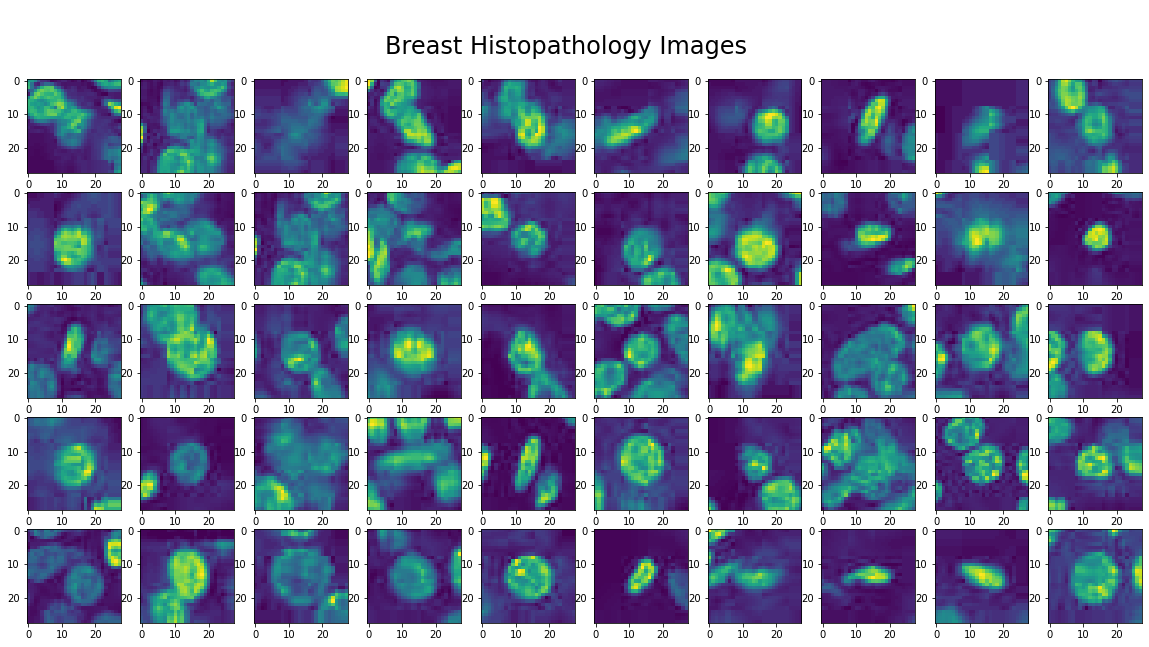

In [2]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/TissueMNIST/subsets/TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [3]:
dataset.head()

,patient_ids,images,labels
0,55614,"[[18, 24, 65, 110, 113, 90, 74, 68, 43, 29, 14...",4
1,55614,"[[5, 6, 9, 12, 10, 9, 15, 24, 33, 28, 28, 31, ...",1
2,55614,"[[15, 11, 10, 11, 10, 6, 6, 9, 9, 11, 12, 12, ...",5
3,55614,"[[6, 5, 5, 5, 5, 5, 4, 4, 8, 7, 6, 5, 5, 6, 6,...",7
4,55614,"[[31, 14, 13, 18, 11, 7, 13, 18, 11, 11, 12, 1...",0


In [4]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (1870, 3, 50, 50)
Dims (241, 3, 50, 50)
Dims (252, 3, 50, 50)
Preprocessing completed.


In [5]:
# run this cell
data_subjects = DataSubjectList.from_series(train["patient_ids"])
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [6]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [7]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [8]:
from syft import nn

In [9]:
input_shape = train_image_data.public_shape
input_shape

(1870, 3, 50, 50)

In [10]:
y_train = train_label_data

In [11]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 3
# model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 4
# model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 6
# model.add(nn.AvgPool(7))

# # Layer 7
model.add(nn.Flatten())

# Layer 8
model.add(nn.Linear(2))

In [12]:
model.compile()

In [13]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1870, 3, 50, 50), (1, 1870))

In [14]:
# for i in train_image_data.child.data_subjects.data_subjects_indexed.flatten():
#     print(i)
#     break


(1, 1881) * ones((1881, 3, 50, 50))

In [15]:
from syft import PhiTensor
def correct_dsl(input_tensor: PhiTensor):
    """ Corrects for the new DSL shape requirements 
    e.g. (1915,) -> (1915, 3, 50, 50) 
    """
    output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
    print(output_dsi.shape)
    
    for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
        output_dsi[index] *= val
    
    input_tensor.data_subjects.data_subjects_indexed = output_dsi
    # print(output_dsi.shape)
    # print(output_dsi[0])
    # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
    # for i in range(input_tensor.shape[0]):
    #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
    # input_tensor.data_subjects.data_subjects_indexed = output_dsi

correct_dsl(train_image_data.child)  
# .shape, train_image_data.child.data_subjects.shape

(1870, 3, 50, 50)


In [16]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1870, 3, 50, 50), (1870, 3, 50, 50))

In [17]:
out = train_image_data[:2].child

In [18]:
out.shape, out.data_subjects.shape

((2, 3, 50, 50), (2, 3, 50, 50))

In [19]:
for layer in model.layers:
    print("Layer Name: ", layer)
    out = layer.forward(out)
    print()

Layer Name:  Convolution
Input into Conv forward: (2, 3, 50, 50) (2, 3, 50, 50)
shapes before padding:,  (2, 3, 50, 50) (2, 3, 50, 50)
dsi_shape, width, mode (2, 3, 50, 50) ((0, 0), (0, 0), (2, 2), (2, 2)) reflect
Done with convolution

Layer Name:  BatchNorm

Layer Name:  MaxPool
shapes before padding:,  (64, 1, 52, 52) (8, 64, 1, 52, 52)
dsi_shape, width, mode (8, 64, 1, 52, 52) ((0, 0), (0, 0), (0, 0), (0, 0)) reflect
FInished im2col, starting _argmax
<class 'numpy.ndarray'>
Got outputs, reshaping now
<class 'numpy.ndarray'>
Reshaped outputs, transposing now
<class 'numpy.ndarray'>
Done with MaxPool forward pass

Layer Name:  Convolution
Input into Conv forward: (2, 32, 26, 26) (8, 2, 32, 26, 26)
shapes before padding:,  (2, 32, 26, 26) (8, 2, 32, 26, 26)
dsi_shape, width, mode (8, 2, 32, 26, 26) ((0, 0), (0, 0), (2, 2), (2, 2)) reflect
Done with convolution

Layer Name:  BatchNorm


ValueError: could not broadcast input array from shape (1,1734,64,28,28) into shape (1,2,64,28,28)

In [21]:
(1/out).shape

(2, 64, 28, 28)

In [22]:
out_mean = out.mean(0)

In [25]:
out_mean.shape

(64, 28, 28)

In [26]:
out_mean.data_subjects.data_subjects_indexed.shape

(578, 64, 28, 28)

In [28]:
diff = out - out_mean

In [29]:
diff.shape, diff.data_subjects.shape

((2, 64, 28, 28), (867, 2, 64, 28, 28))

### Loss calculation

In [ ]:
y_true = train_label_data[:2].child

In [ ]:
y_true.child

In [ ]:
out.child.shape

In [ ]:
next_grad = model.loss.backward(out, y_true)

In [ ]:
for layer in model.layers[::-1]:
    print(layer)
    next_grad = layer.backward(next_grad)

In [ ]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)